In [113]:
from IPython.display import HTML, display
css_file_path = "../../design/custom.css"
styles = "<link rel='stylesheet' href='%s'>" % css_file_path
display(HTML(styles))

# VOLATILITY ANALYSIS

**Financial volatility** is a concept that refers to the variation in the price or return of a stock or other financial asset over a period of time. Volatility implies variability, instability, risk, oscillation in the trajectory of something over a period of time.

Thus, if the price of an asset oscillates a lot, it is said to be very volatile.

In the financial sphere, volatility indicates the fluctuation of the return or price of an asset with respect to its historical average price.

It is a concept that is useful to know for **risk management**, since the higher the volatility of an asset, the greater the risk that the return will be different from the expected return.

Volatility is expressed as a **percentage**, which indicates how much the return on an asset can vary according to its past performance.

There are four types of volatility:

- **Historical volatility**: this is the volatility that an asset has had in the past.

- Implied volatility**: the volatility that an asset is expected to have in the future.

- Deterministic volatility**: is the volatility that can be calculated from a mathematical model. The **standard deviation** of an asset's returns is often used.

- Stochastic volatility**: Volatility that can be calculated from a mathematical model and takes into account the randomness of the data.



**HOW IS VOLATILITY CALCULATED?**



1. The daily returns of an asset are calculated:

$$r_i = log(\frac{p_i}{p_{i-1}})= log(p_i) - log(p_{i-1})$$

2. The returns are averaged:

$$\bar{r} = \frac{1}{n} \sum_{i=1}^n r_i$$

3. The standard deviation of the returns is calculated:

$$\sigma = \sqrt{\frac{1}{n-1} \sum_{i=1}^{n} (r_i - \bar{r})^2}$$

where $p_i$ and $p_{i-1}$ are the asset prices at instants $i$ and $i-1$, respectively, and $n$ is the number of returns we have, i.e. the length of the time window being processed.

**NOTEBOOK INDEX:**

1. Loading data, calculating returns and volatility

2. Calculate weekly, monthly, yearly volatility.

3. Comparison of returns of assets with different volatility.

4. Effect of using different time windows for volatility calculation

5. Time-varying volatility

6. Interpretation of high and low volatility

7. Volatility characteristics and volatility forecasting

In [114]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
import cvxpy as cp
import plotly.graph_objects as go
from tqdm import tqdm

from arch import arch_model

plt.style.use('ggplot')


## 1. Load data, calculate returns and volatility

We load a couple of datasets. 

In [115]:
data_OHLC_df = pd.read_excel('../data/data_OHLC.xlsx', header=[0, 1], index_col=0, parse_dates=True)
data_OHLC_df_corr = pd.read_excel('../data/data_OHLC_corr.xlsx', header=[0, 1], index_col=0, parse_dates=True)

We calculate the logarithmic returns.

In [116]:
data_close_df = data_OHLC_df['Adj Close'].dropna()
ret_close_df = np.log(data_close_df).diff().dropna()

data_close_df_corr = data_OHLC_df_corr['Adj Close'].dropna()
ret_close_df_corr = np.log(data_close_df_corr).diff().dropna()

We calculate the means and variances of the two datasets.

In [117]:
means = ret_close_df.mean()
stds = ret_close_df.std()
means_corr = ret_close_df_corr.mean()
stds_corr = ret_close_df_corr.std()

We visualise the return and volatility of the assets in the two datasets.

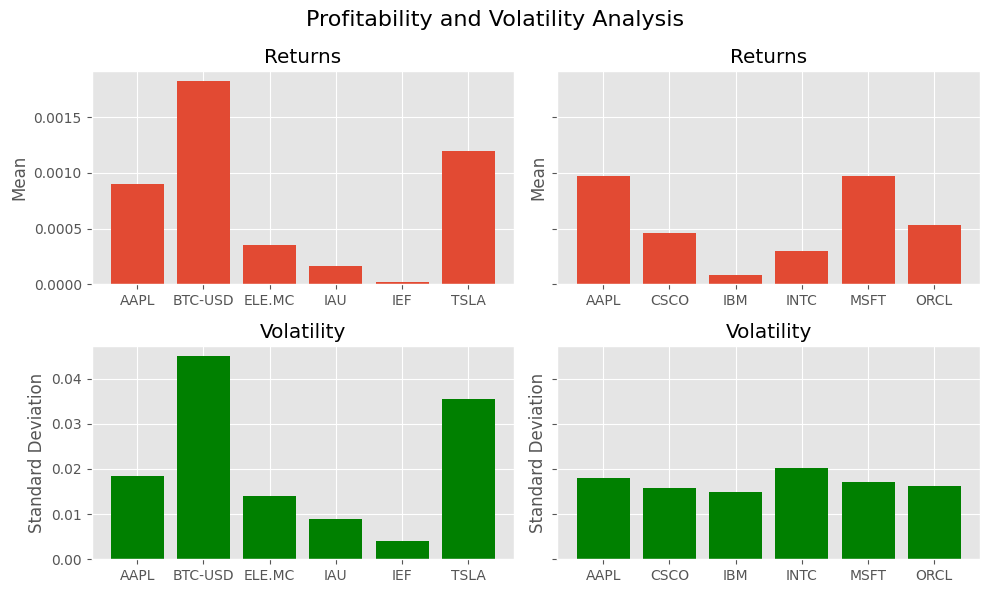

In [118]:
# Crear una figura con dos subplots, uno encima del otro
fig, axes = plt.subplots(2, 2, figsize=(10, 6), sharey='row')

# Crear el gráfico de barras de los valores medios en la parte superior
axes[0, 0].bar(means.index, means.values)
axes[0, 0].set_ylabel('Mean')
axes[0, 0].set_title('Returns')

# Crear el gráfico de barras de los valores de desviación estándar en la parte inferior
axes[1, 0].bar(stds.index, stds.values,color='green')
axes[1, 0].set_ylabel('Standard Deviation')
axes[1, 0].set_title('Volatility')

#Crear una figura con dos subplots, uno encima del otro
axes[0, 1].bar(means_corr.index, means_corr.values)
axes[0, 1].set_ylabel('Mean')
axes[0, 1].set_title('Returns')

# Crear el gráfico de barras de los valores de desviación estándar en la parte inferior
axes[1, 1].bar(stds_corr.index, stds_corr.values,color='green')
axes[1, 1].set_ylabel('Standard Deviation')
axes[1, 1].set_title('Volatility')

# Añadir un título general a la figura
plt.suptitle('Profitability and Volatility Analysis', fontsize=16)  # Título general

# Ajustar el espaciado entre los subplots para que no se superpongan
plt.tight_layout()

# Mostrar el gráfico
plt.show()

<hr>

## 2. Volatility calculation weekly, monthly, yearly

To calculate volatility in a period other than daily, it should be taken into account that:

$$\sigma_T = \sqrt{T} * \sigma_{día}$$

Then:

- Weekly volatility: $\sigma_{week} = \sqrt{5} * \sigma_{day}$

- Monthly volatility: $\sigma_{month} = \sqrt{21} * \sigma_{day}$

- Annual volatility: $\sigma_{year} = \sqrt{252} * \sigma_{day}$


In [119]:
ret_close_df.head()

,AAPL,BTC-USD,ELE.MC,IAU,IEF,TSLA
Date,,,,,,
2014-09-18,0.002065,-0.074643,0.008327,0.002533,-0.000683,0.009292
2014-09-19,-0.008187,-0.072402,0.004727,-0.005920,0.003795,-0.017204
2014-09-22,0.000990,0.018461,0.009055,-0.002548,0.002135,-0.036482
2014-09-23,0.015514,0.080333,0.001501,0.005935,0.002130,0.001519
2014-09-24,-0.008709,-0.029306,0.012587,-0.003387,-0.002809,0.006885


In [120]:
# Multiplicamos * 100 para visualizar un porcentaje
daily_volatility = 100*ret_close_df['AAPL'].std()
print('Daily volatility: ', '{:.2f}%'.format(daily_volatility))

monthly_volatility = math.sqrt(21) * daily_volatility
print ('Monthly volatility: ', '{:.2f}%'.format(monthly_volatility))

annual_volatility = math.sqrt(252) * daily_volatility
print ('Annual volatility: ', '{:.2f}%'.format(annual_volatility))

Daily volatility:  1.84%
Monthly volatility:  8.45%
Annual volatility:  29.27%


<hr>

## 3. Comparison of asset returns with different volatilities

Let us now look at the daily returns of an asset with high volatility, e.g. `Bitcoin`, versus another with low volatility, e.g. `iShares 7-10 Year Treasury Bond ETF`.

In [121]:
# Crear un gráfico de líneas con Plotly
fig = go.Figure()

fig.add_trace(go.Scatter(x=ret_close_df.loc['2016-05-01':,  :].index, 
                         y=ret_close_df.loc['2016-05-01':,  :]['BTC-USD'], 
                         mode='lines',
                         name='BTC-USD'))

fig.add_trace(go.Scatter(x=ret_close_df.loc['2016-05-01':,  :].index, 
                         y=ret_close_df.loc['2016-05-01':,  :]['IEF'], 
                         mode='lines',
                         name='IEF')) #iShares 7-10 Year Treasury Bond ETF

# Añadir títulos
fig.update_layout(
    title="COMPARISON OF HIGH AND LOW VOLATILITY ASSETS",
    title_font=dict(size=18),  # Ajusta el tamaño del título
    title_x=0.5,  # Centra el título
    yaxis_title="Daily returns %",
    margin=dict(l=20, r=20, b=20, t=40),  # Ajusta los márgenes para hacer los bordes más pequeños
)

Another way is to visualise the distribution of daily returns.

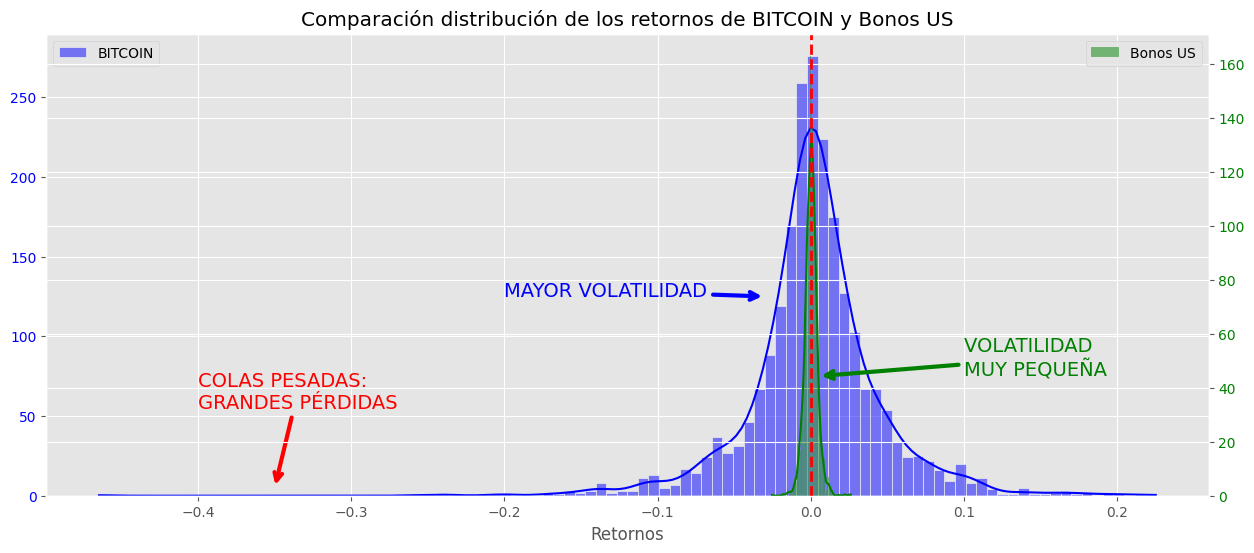

In [122]:
fig, ax1 = plt.subplots(figsize=(15, 6))

# Crear el primer gráfico con sns.histplot
sns.histplot(data=ret_close_df, x='BTC-USD', ax=ax1, bins=100, color='blue', kde=True, alpha=0.5, label='BITCOIN')
ax1.set_xlabel('Retornos')
ax1.set_ylabel('', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.legend(loc='upper left')

# # Añadir texto en ax2
# text_x = -0.4
# text_y = 25

#ax1.text(-0.2, 125, f"MAYOR VOLATILIDAD", fontsize=12, color='blue')

ax1.annotate('MAYOR VOLATILIDAD', xy=(-0.03, 125), xytext=(-0.2, 125),
            arrowprops=dict(arrowstyle='->', linewidth=3, color='blue'),
            fontsize=14, color='blue')

ax1.annotate('VOLATILIDAD \nMUY PEQUEÑA', xy=(0.005, 75), xytext=(0.1, 75),
            arrowprops=dict(arrowstyle='->', linewidth=3, color='green'),
            fontsize=14, color='green')

ax1.annotate('COLAS PESADAS: \nGRANDES PÉRDIDAS', xy=(-0.35, 5), xytext=(-0.4, 55),
            arrowprops=dict(arrowstyle='->', linewidth=3, color='red'),
            fontsize=14, color='RED')



# Duplicar el eje Y para el segundo gráfico
ax2 = ax1.twinx()

# Crear el segundo gráfico con sns.histplot
sns.histplot(data=ret_close_df, x='IEF', ax=ax2, bins=100, color='green', kde=True, alpha=0.5, label='Bonos US')
ax2.set_ylabel('', color='green')
ax2.tick_params(axis='y', labelcolor='green')
ax2.legend(loc='upper right')

# Añadir una línea vertical en el eje X en 0
plt.axvline(x=0, color='red', linestyle='--', linewidth=2)
# Configurar título y mostrar el gráfico
plt.title('Comparación distribución de los retornos de BITCOIN y Bonos US')
plt.show()

<hr>

## 4. Effect of using different time windows for volatility calculation

**BEFORE LET'S EXPLAIN WHAT ROLLING WINDOWS ARE IN TIME SERIES ANALYSIS:**

Pandas has 3 main methods that allow us to perform aggregation operations on sliding windows of data:

* __rolling()__ sliding window

* __expanding()__ expanding window

* __ewm()__ exponentially weighted


For detailed information on these methods click [here](https://pandas.pydata.org/docs/user_guide/window.html)

The two most commonly used methods are:

<br>
<br>
<center>
<img src="../imgs/pandas windows.jpeg"  alt="drawing" width="30%"/>
</center>

The __rolling()__ function allows us to apply various functions on the data contained in the sliding windows. The main parameters are:

* window: window size
* min_periods: minimum number of periods with data to return a value.
* center: if True the window will be centered. Default is False.

The full documentation is [here](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.rolling.html)

In [123]:
mean_3 = ret_close_df[:200]['AAPL'].rolling(window=3).mean()
mean_20 = ret_close_df[:200]['AAPL'].rolling(window=20).mean()
mean_60 = ret_close_df[:200]['AAPL'].rolling(window=60).mean()

rets = ret_close_df.iloc[:200]['AAPL']


In [124]:
# Create a figure
fig = go.Figure()

# Add the original returns trace
fig.add_trace(go.Scatter(
    x=rets.index,
    y=rets,
    mode='lines',
    name='Original Returns',
    line=dict(color='blue', width=1),
    opacity=0.5
))

# Add the 3-day rolling mean trace
fig.add_trace(go.Scatter(
    x=mean_3.index,
    y=mean_3,
    mode='lines',
    name='3-Day Rolling Mean',
    line=dict(color='red', width=2)
))

# Add the 21-day rolling mean trace
fig.add_trace(go.Scatter(
    x=mean_20.index,
    y=mean_20,
    mode='lines',
    name='21-Day Rolling Mean',
    line=dict(color='green', width=2)
))

# Add the 63-day rolling mean trace
fig.add_trace(go.Scatter(
    x=mean_60.index,
    y=mean_60,
    mode='lines',
    name='63-Day Rolling Mean',
    line=dict(color='purple', width=2)
))

# Update the layout for better presentation
fig.update_layout(
    title='AAPL Returns with Different Rolling Windows',
    xaxis_title='Date',
    yaxis_title='Returns',
    legend_title='Window Size',
    template='plotly_white',
    width=1600,
    height=600
)

# Show the plot
fig.show()

#### **Let's take a closer look at the volatility of Apple's closing share prices.**

In [125]:
start_date = "2011-01-04"
end_date = "2021-04-30"

In [126]:
ticker= "aapl"
aapl_df = yf.download(ticker, start=start_date, end=end_date)[['Adj Close']].copy()

[*********************100%***********************]  1 of 1 completed


In [127]:
aapl_df['Return'] = 100*np.log(aapl_df['Adj Close']).diff()
aapl_df.head()

,Adj Close,Return
Date,,
2011-01-04,9.991650,NaN
2011-01-05,10.073383,0.814692
2011-01-06,10.065241,-0.080864
2011-01-07,10.137324,0.713610
2011-01-10,10.328233,1.865710


Let us now look at the effect of calculating volatility using different time windows using Pandas `rolling`.

In [128]:
aapl_df['Vol_5'] = aapl_df['Return'].rolling(5).std()
aapl_df['Vol_20'] = aapl_df['Return'].rolling(20).std()
aapl_df['Vol_60'] = aapl_df['Return'].rolling(60).std()
aapl_df['Vol_252'] = aapl_df['Return'].rolling(252).std()

In [129]:
aapl_vol = aapl_df.loc[:, ['Vol_5', 'Vol_20', 'Vol_60', 'Vol_252']].dropna()
aapl_vol_filtered = aapl_vol['2016-01-01':'2019-12-31']

In [130]:
# Inicializar la figura
fig = go.Figure()


# Añadir cada columna del DataFrame como una traza
for col in aapl_vol_filtered.columns:
    fig.add_trace(go.Scatter(x=aapl_vol_filtered.index, 
                             y=aapl_vol[col], 
                             mode='lines',
                             name=col))

# Configurar el diseño y mostrar la figura
fig.update_layout(title="Volatilidades de AAPL con distintas ventanas de tiempo",
                    title_font=dict(size=24),  # Ajusta el tamaño del título
                    title_x=0.5,  # Centra el título
                    xaxis_title="Fecha",
                    yaxis_title="Volatilidad")
fig.show()

<hr>

## 5. Time-varying volatility

Let's look at how the volatility of Apple's closing share prices varies over time.

In [131]:
# Calculamos las volatilidades en distintos periodos de tiempo

std1 = aapl_df.loc["2016-05-01":"2018-09-01", ['Return']].std()
std2 = aapl_df.loc["2018-09-01":"2020-02-29", ['Return']].std()
std3 = aapl_df.loc["2020-02-29":"2021-04-30", ['Return']].std()

In [132]:
# Crear un gráfico de líneas con Plotly
fig = go.Figure()

fig.add_trace(go.Scatter(x=aapl_df.loc['2016-05-01':,  :].index, 
                         y=aapl_df.loc['2016-05-01':,  :]['Return'], 
                         mode='lines',
                         name='Return'))


# Añadir anotación para resaltar la baja volatilidad
fig.add_annotation(
    x="2017-07-01",  # Aproximadamente en el medio del período para que el texto aparezca centrado
    #y=stock_data['Return'].max(),  # Esto coloca la anotación cerca del valor máximo de 'Return'. Puedes ajustarlo según tus necesidades.
    y=4,
    text="Low volatility in 2017",
    showarrow=True,
    arrowhead=4,
    ax=0,
    ay=-40,
    arrowsize=2,  # Ajusta el tamaño de la flecha
    font=dict(size=16,  # Ajusta el tamaño de la letra
              color="black"),  # Color de la letra, si lo deseas cambiar
    bgcolor="rgba(255, 227, 227, 0.9)",  # Color de fondo para la anotación
    bordercolor="rgba(255, 0, 0, 0.9)",  # Color del borde para la anotación
    borderwidth=2
)

# Añadir anotación para resaltar la baja volatilidad
fig.add_annotation(
    x="2020-07-01",  # Aproximadamente en el medio del período para que el texto aparezca centrado
    #y=stock_data['Return'].max(),  # Esto coloca la anotación cerca del valor máximo de 'Return'. Puedes ajustarlo según tus necesidades.
    y=7,
    text="High volatility in 2020",
    showarrow=True,
    arrowhead=4,
    ax=0,
    ay=-70,
    arrowsize=2,  # Ajusta el tamaño de la flecha
    font=dict(size=16,  # Ajusta el tamaño de la letra
              color="black"),  # Color de la letra, si lo deseas cambiar
    bgcolor="rgba(255, 227, 227, 0.9)",  # Color de fondo para la anotación
    bordercolor="rgba(255, 0, 0, 0.9)",  # Color del borde para la anotación
    borderwidth=2
)

# Añadir un segmento horizontal
fig.add_shape(
    type="line",
    x0="2016-05-01",  # Desde el inicio de tus datos
    x1="2018-09-01",  # Hasta finales de febrero de 2020
    y0=2*std1.values[0],
    y1=2*std1.values[0],
    line=dict(color="green", width=2)
)

# Añadir un segmento horizontal
fig.add_shape(
    type="line",
    x0="2016-05-01",  # Desde el inicio de tus datos
    x1="2018-09-01",  # Hasta finales de febrero de 2020
    y0=-std1.values[0],
    y1=-std1.values[0],
    line=dict(color="green", width=2)
)

# Añadir un segmento horizontal
fig.add_shape(
    type="line",
    x0='2018-09-01',  # Desde el inicio de tus datos
    x1="2020-02-29",  # Hasta finales de febrero de 2020
    y0=2*std2.values[0],
    y1=2*std2.values[0],
    line=dict(color="purple", width=2)
)

# Añadir un segmento horizontal
fig.add_shape(
    type="line",
    x0='2018-09-01',  # Desde el inicio de tus datos
    x1="2020-02-29",  # Hasta finales de febrero de 2020
    y0=-2*std2.values[0],
    y1=-2*std2.values[0],
    line=dict(color="purple", width=2)
)

# Añadir un segmento horizontal
fig.add_shape(
    type="line",
    x0='2020-02-29',  # Desde el inicio de tus datos
    x1='2021-04-29',  # Hasta finales de febrero de 2020
    y0=2*std3.values[0],
    y1=2*std3.values[0],
    line=dict(color="red", width=2)
)

# Añadir un segmento horizontal
fig.add_shape(
    type="line",
    x0='2020-02-29',  # Desde el inicio de tus datos
    x1='2021-04-29',  # Hasta finales de febrero de 2020
    y0=-2*std3.values[0],
    y1=-2*std3.values[0],
    line=dict(color="red", width=2)
)

# Añadir etiqueta a la línea
fig.add_annotation(
    text="The lines represent ±2σ",
    x='2017-07-01',
    y=-3,
    font=dict(size=18,  # Ajusta el tamaño de la letra
            color="black"),  # Color de la letra, si lo deseas cambiar
    showarrow=True,
    arrowhead=4,
    ax=0,
    ay=50,
    arrowsize=2,  # Ajusta el tamaño de la flecha
    bgcolor="rgba(204, 255, 204, 0.9)",  # Color de fondo verde claro
    bordercolor="rgba(0, 128, 0, 0.9)",  # Color de borde verde oscuro
    borderwidth=2
)


# Añadir títulos
fig.update_layout(
    title="Apple's periods of volatility",
    title_font=dict(size=24),  # Ajusta el tamaño del título
    title_x=0.5,  # Centra el título
    yaxis_title="Daily Returns %",
    margin=dict(l=20, r=20, b=20, t=40)  # Ajusta los márgenes para hacer los bordes más pequeños
)

fig.show()


## 6. High and low volatility interpretation

We are going to analyse what it means for volatility to be high or low. To do so, we are going to analyse the price evolution of the S&P 500 index and the VIX volatility index.

Por more information about the VIX index click [here](https://www.cboe.com/tradable_products/vix/)

In [133]:
# Descargar datos del S&P 500 y VIX
sp500 = yf.download('^GSPC', start="2000-01-01", end="2022-01-01")
vix = yf.download('^VIX', start="2000-01-01", end="2022-01-01")

[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed


In [134]:
# Crear un gráfico con Plotly
fig = go.Figure()

# Añadir datos del S&P 500 al gráfico (eje y principal)
fig.add_trace(go.Scatter(x=sp500.index, 
                         y=sp500['Close'], 
                         mode='lines',
                         name='S&P 500'))

# Añadir datos del VIX al gráfico (eje y secundario)
fig.add_trace(go.Scatter(x=vix.index, 
                         y=vix['Close'], 
                         mode='lines',
                         name='VIX',
                         yaxis="y2",
                         opacity=0.7))  # Especifica que esta traza debe usar el eje y secundario

# Añadir la anotación solicitada
fig.add_annotation(
    x="2008-07-01",  # Mueve la posición x del texto a 2008
    y=4000,  # Ubicación en el eje y para la anotación
    yref="y1",  # Referencia al eje y principal (S&P 500)
    text="Volatility rises when the market goes down",
    font=dict(size=16,  # Ajusta el tamaño de la letra
              color="black"),  # Color de la letra, si lo deseas cambiar
    showarrow=True,  # Muestra la flecha
    arrowhead=2,  # Estilo de la cabeza de la flecha
    arrowsize=1,  # Tamaño de la flecha
    arrowwidth=2,  # Ancho de la flecha
    arrowcolor="#636363",  # Color de la flecha
    axref="x",  # Referencia para la posición ax
    #ayref="y1",  # Referencia para la posición ay
    ax="2004",  # Cambia la dirección de la flecha para que apunte a 2005
    ay=-30,  # Dónde debe apuntar la flecha en el eje y secundario
    bgcolor="rgba(255, 227, 227, 0.9)",  # Color de fondo de la anotación
    bordercolor="rgba(255, 0, 0, 0.9)",  # Color del borde de la anotación
    borderwidth=2  # Ancho del borde de la anotación
)

# Añadir la anotación solicitada
fig.add_annotation(
    x="2020",  # Mueve la posición x del texto a 2008
    y=4000,  # Ubicación en el eje y para la anotación
    yref="y1",  # Referencia al eje y principal (S&P 500)
    text="",
    showarrow=True,  # Muestra la flecha
    arrowhead=2,  # Estilo de la cabeza de la flecha
    arrowsize=1,  # Tamaño de la flecha
    arrowwidth=2,  # Ancho de la flecha
    arrowcolor="#636363",  # Color de la flecha
    axref="x",  # Referencia para la posición ax
    #ayref="y1",  # Referencia para la posición ay
    ax="2007-06-01",  # Cambia la dirección de la flecha para que apunte a 2005
    ay=-30,  # Dónde debe apuntar la flecha en el eje y secundario

)

# Añadir la anotación solicitada
fig.add_annotation(
    x="2015",  # Mueve la posición x del texto a 2008
    y=2500,  # Ubicación en el eje y para la anotación
    yref="y1",  # Referencia al eje y principal (S&P 500)
    text="Volatility is low when the market is going up",
    font=dict(size=16,  # Ajusta el tamaño de la letra
              color="black"),  # Color de la letra, si lo deseas cambiar
    showarrow=True,  # Muestra la flecha
    arrowhead=2,  # Estilo de la cabeza de la flecha
    arrowsize=1,  # Tamaño de la flecha
    arrowwidth=2,  # Ancho de la flecha
    arrowcolor="#636363",  # Color de la flecha
    #axref="x",  # Referencia para la posición ax
    #ayref="y1",  # Referencia para la posición ay
    ax=0,  # Cambia la dirección de la flecha para que apunte a 2005
    ay=-80,  # Dónde debe apuntar la flecha en el eje y secundario
    bgcolor="rgba(255, 227, 227, 0.9)",  # Color de fondo de la anotación
    bordercolor="rgba(255, 0, 0, 0.9)",  # Color del borde de la anotación
    borderwidth=2  # Ancho del borde de la anotación
)

# Configuración del layout del gráfico
fig.update_layout(title="S&P 500 and VIX from 2000 to 2022",
                  title_font=dict(size=24),  # Ajusta el tamaño del título
                  title_x=0.5,  # Centra el título
                  xaxis_title="Fecha",
                  yaxis_title="Precio de cierre S&P 500",
                  yaxis2=dict(title="VIX", 
                              overlaying='y', 
                              side='right'),  # Configuración del eje y secundario
                 )

fig.show()


## 7. Volatility Characteristics and Predictability

#### **CHARACTERISTICS**.

1- **Measure of Risk**: 

Volatility is used as an indicator of an asset's risk. An asset with higher volatility is seen as riskier because its returns are less predictable.

2- **Clustering**: 

Volatility tends to cluster. Days of high or low returns tend to be clustered, meaning that periods of high volatility are followed by more periods of high volatility and vice versa.

3- **Persistence or Memory Effect**: 

This is a manifestation of autocorrelation in volatility, where past volatility affects future volatility.

4- **Asymmetry**: 

Assets often react differently to positive and negative price movements. Specifically, the impact of returns on volatility is often stronger in bear markets than in bull markets, especially in equity markets.

5- **Reaction to Events**: 

Volatility may spike following significant financial events or unexpected news, reflecting uncertainty in the market.

6- **Reversion to the Mean**: 

Although a moot point, many models and observations suggest that volatility tends to revert to long-term or unconditional volatility. This idea was incorporated in models such as Robert Engle's ARCH.



_________________________
## ANNEX

&nbsp;

#### **PREDICCIÓN DE LA VOLATILIDAD**



El **modelo GARCH** (Generalized Autoregressive Conditional Heteroskedasticity) es especialmente adecuado para predecir la volatilidad de los activos financieros debido a cómo aborda las características inherentes de la volatilidad:

1- **Persistencia o Efecto "Memoria":**

GARCH captura la autocorrelación en la volatilidad, permitiendo que la volatilidad de hoy dependa de las volatilidades y shocks pasados. Esto es esencial para modelar la "memoria" o persistencia en la volatilidad.


2- **Agrupación (Clusters):**

Dada su estructura, el modelo GARCH es capaz de capturar los períodos de agrupación en la volatilidad, donde días de alta o baja volatilidad tienden a seguirse.

3- **Asimetría:** 

Algunas variantes del modelo GARCH, como el EGARCH, pueden capturar la asimetría en la volatilidad, reflejando la observación de que los mercados a menudo reaccionan de manera diferente a movimientos de precios positivos y negativos.

4- **Reversión a la Media:** 

La estructura del modelo GARCH implica una reversión a la media, ya que la volatilidad se modela como una combinación de la volatilidad de largo plazo (incondicional) y los efectos de shocks recientes.


## MODELO GARCH

1- Ecuación de los retornos:

$$r_t = \mu + \epsilon_t$$

donde:
- $r_t$ es el retorno en el instante $t$,

- $\epsilon_t$ es el shock en el instante $t$,


- $\mu$ es la media de los retornos. 
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Es un término constante que captura la tendencia central o el "nivel base" de los retornos de un activo o serie temporal. En otras palabras, es el retorno medio o constante que se espera independientemente de los shocks o perturbaciones.


&nbsp;

2 - Ecuación de la Volatilidad:

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;$\sigma_t² = \alpha_0 + \sum_{i=1}^p \alpha_i * \epsilon_{t-i}² + \sum_{j=1}^q \beta_j * \sigma_{t-j}²$

donde:

- $\sigma_t²$ es la varianza de los retornos en el instante $t$,

- $\alpha_0$ es la varianza incondicional de los retornos,

- $\alpha_i$ son los coeficientes que capturan el impacto de los residuos al cuadrado (shocks) pasados en la volatilidad actual,

- $\beta_j$ son los coeficientes que capturan el impacto de la volatilidad pasada en la volatilidad actual,

- $p$ es el orden del modelo AR,

- $q$ es el orden del modelo MA.

&nbsp;

3 - Ecuación de Shock

El residuo o shock $\epsilon_t$ se define en función de la volatilidad condicional y un término de error $z_t$ que sigue una distribución normal estándar:

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;$\epsilon_t = \sigma_t * z_t$

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;$z_t \sim N(0,1)$




&nbsp;

Si suponemos que los shocks solo dependen del instante anterior, entonces tenemos un modelo GARCH(1,1).


En el caso de un modelo GARCH(1,1) tenemos:

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;$\sigma_t² = \alpha_0 + \alpha_1 * \epsilon_{t-1}² + \beta_1 * \sigma_{t-1}²$

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;$\epsilon_t = \sigma_t * z_t$

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;$z_t \sim N(0,1)$

- Ecuación de los retornos:

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;$r_t = \mu + \epsilon_t$


Definimos el modelo GARCH(1,1) y lo ajustamos a los retornos de las acciones de Apple

In [135]:
aapl_df['Return'].dropna(inplace=True)

In [136]:
aapl_returns = aapl_df['Return'].dropna()

In [137]:
garch_model = arch_model(aapl_returns, p = 1, q = 1,
                      mean = 'constant', vol = 'GARCH', dist = 'normal') # Crear el modelo

gm_result = garch_model.fit(disp='off')
print(gm_result.params) # Imprime los parámetros del modelo

print('\n')

gm_forecast = gm_result.forecast(horizon = 5) # Pronostica 5 periodos hacia adelante
print(gm_forecast.variance[-1:]) # Imprime la varianza pronosticada 

mu          0.168157
omega       0.192923
alpha[1]    0.131226
beta[1]     0.812904
Name: params, dtype: float64


                 h.1       h.2       h.3      h.4      h.5
Date                                                      
2021-04-29  1.689937  1.788442  1.881444  1.96925  2.05215


VAmos a predecir la volatilidad de los retornos de las acciones de Apple usando el modelo GARCH(1,1) para los siguientes 365 días

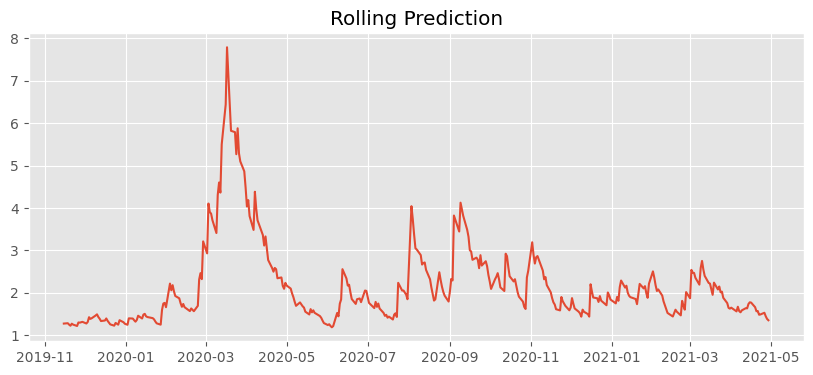

In [138]:
rolling_predictions = [] # Lista para almacenar las predicciones
test_size = 365 # Tamaño del conjunto de prueba

for i in range(test_size):
    train = aapl_returns[:-(test_size-i)] # Entrenar el modelo sin el último valor
    model = arch_model(train, p=1, q=1) # Crear el modelo
    model_fit = model.fit(disp='off') # Ajustar el modelo
    pred = model_fit.forecast(horizon=1)    # Pronosticar un periodo hacia adelante
    rolling_predictions.append(np.sqrt(pred.variance.values[-1,:][0])) # Añadir la predicción a la lista
    
rolling_predictions = pd.Series(rolling_predictions, index=aapl_returns.index[-365:]) # Crear una serie con las predicciones

plt.figure(figsize=(10,4))
plt.plot(rolling_predictions)
plt.title('Rolling Prediction')
plt.show()

In [143]:
# Crear un gráfico con Plotly
fig = go.Figure()

# Añadir datos del S&P 500 al gráfico (eje y principal)
fig.add_trace(go.Scatter(x=aapl_returns[-365:].index, 
                         y=aapl_returns[-365:], 
                         mode='lines',
                         name='AAPL'))

# Añadir datos del VIX al gráfico (eje y secundario)
fig.add_trace(go.Scatter(x=rolling_predictions.index, 
                         y=rolling_predictions, 
                         mode='lines',
                         line=dict(color='red'),
                         name='FORECASTING',
                         opacity=0.7))  

# Añadir datos del VIX al gráfico (eje y secundario)
fig.add_trace(go.Scatter(x=rolling_predictions.index, 
                         y=-rolling_predictions, 
                         mode='lines',
                         line=dict(color='red'),
                         showlegend=False,
                         opacity=0.7))  

# Configuración del layout del gráfico
fig.update_layout(title="AAPL VOLATILITY FORECASTING",
                  title_font=dict(size=24),  # Ajusta el tamaño del título
                  title_x=0.5,  # Centra el título
                  xaxis_title="Dates",
                  yaxis_title="Returns %",
                  height=600,  # Ajusta la altura de la figura
                  width = 1400, # Ajusta el ancho de la figura
                  margin=dict(l=20, r=20, b=30, t=50)
                 )
